In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import yfinance as yf

In [22]:
df=pd.read_csv('crsp_daily_data_monthly_spy.csv')
df['RET']=pd.to_numeric(df['RET'],errors='coerce')
df['date'] = pd.to_datetime(df['date'])
df.dropna(subset=['RET'],inplace=True)
#drop unamed 0 column
df.drop(columns=['Unnamed: 0'],inplace=True)

In [23]:
df

,date,TICKER,RET
0,1990-01-02,SUNW,0.043478
1,1990-01-03,SUNW,0.000000
2,1990-01-04,SUNW,-0.013889
3,1990-01-05,SUNW,0.000000
4,1990-01-08,SUNW,0.007042
...,...,...,...
3286620,2015-12-24,TSLA,0.003788
3286621,2015-12-28,TSLA,-0.007026
3286622,2015-12-29,TSLA,0.035990
3286623,2015-12-30,TSLA,0.003794


In [25]:
import pandas as pd
from tqdm import tqdm

# Sample data loading. Adjust this according to your actual data
# df = pd.read_csv('your_data.csv')
# Ensure 'date' column is datetime
# df['date'] = pd.to_datetime(df['date'])

# Setting the initial start date and end date
start_date = pd.Timestamp('1996-01-03')
end_date = pd.Timestamp('2015-10-30')

study_periods = []
window_size = 240  # Adjust the window size as needed

# Iterate through the DataFrame with a step size of 250 days (the length of the trading period)
for start in tqdm(pd.date_range(start=start_date, end=end_date, freq='250D')):
    train_start = start
    train_end = start + pd.DateOffset(days=750)
    trade_end = train_end + pd.DateOffset(days=250)
    
    if trade_end > end_date:
        print("Reached the end of the dataset.")
        break

    # Create separate DataFrames for training and trading periods
    train_df = df[(df['date'] >= train_start) & (df['date'] < train_end)].copy()
    trade_df = df[(df['date'] >= train_end) & (df['date'] < trade_end)].copy()
    
    if train_df.empty:
        print(f"No data available from {train_start.date()} to {train_end.date()}. Skipping.")
        continue

    # Standardize returns with a rolling window
    train_df['rolling_mean'] = train_df.groupby('TICKER')['RET'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    #Mu and sigma are only calculated on the training data
    mu = train_df['rolling_mean'].mean()
    sigma = train_df['rolling_mean'].std()
    train_df['standardized_return'] = (train_df['rolling_mean'] - mu) / sigma

    # Standardize returns for trade_df using the mean and std dev from train_df
    trade_df['rolling_mean'] = trade_df.groupby('TICKER')['RET'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    trade_df['standardized_return'] = (trade_df['rolling_mean'] - mu) / sigma
    
    # Assign binary targets based on whether the standardized return is above the median
    median_standardized_return = train_df['standardized_return'].median()
    train_df['target'] = (train_df['standardized_return'] >= median_standardized_return).astype(int)
    trade_df['target'] = (trade_df['standardized_return'] >= median_standardized_return).astype(int)

    # Store the training and trading DataFrames in the study_periods list
    study_periods.append((train_df, trade_df))

    # print(f"Period: Training {train_start.date()} to {train_end.date()}, Trading {train_end.date()} to {trade_end.date()}")




 86%|████████▌ | 25/29 [00:10<00:01,  2.42it/s]

Reached the end of the dataset.


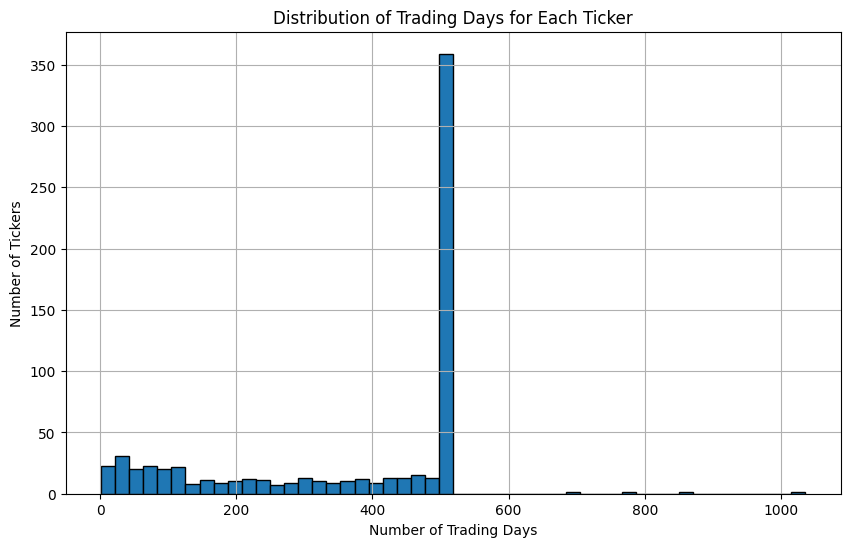

In [26]:
data_counts = study_periods[18][0].value_counts('TICKER')

# Plotting
plt.figure(figsize=(10,6))
plt.hist(data_counts, bins=50, edgecolor='k') 
# You can change bins=50 to another value to have more or less bars in your histogram

plt.title('Distribution of Trading Days for Each Ticker')
plt.xlabel('Number of Trading Days')
plt.ylabel('Number of Tickers')
plt.grid(True)

# Show the plot
plt.show()




In [27]:
study_periods[0][0].head()

,date,TICKER,RET,rolling_mean,standardized_return,target
1518,1996-01-03,SUNW,-0.078212,-0.078212,-26.080652,0
1519,1996-01-04,SUNW,-0.018182,-0.048197,-16.229636,0
1520,1996-01-05,SUNW,0.000000,-0.032131,-10.956834,0
1521,1996-01-08,SUNW,-0.009259,-0.026413,-9.080141,0
1522,1996-01-09,SUNW,-0.068536,-0.034838,-11.845105,0


In [28]:
#check the amount of rows for each ticker in study_periods
for i in study_periods:
    print(i[0]['TICKER'].value_counts())
    break

BRK     736
VIA     554
RTN     540
SUNW    519
LNC     519
       ... 
AC       13
AEE      13
BFO      13
LSP       8
CSRV      7
Name: TICKER, Length: 707, dtype: int64


In [29]:
from torch.utils.data import DataLoader, TensorDataset
import torch
train_test_splits = []

from joblib import Parallel, delayed
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

def process_window(in_sample_df, out_of_sample_df, window_size):
    in_sample_data = []
    in_sample_labels = []

    for i in range(0, len(in_sample_df) - window_size + 1):
        window = in_sample_df.iloc[i: i + window_size]
        features = window[['standardized_return']].values
        label = window['target'].iloc[-1]  # Getting the last day's label
        in_sample_data.append(features)
        in_sample_labels.append(label)

    # Converting lists to numpy arrays
    in_sample_data = np.array(in_sample_data)
    in_sample_labels = np.array(in_sample_labels)

    # Creating tensors from numpy arrays
    train_data = torch.tensor(in_sample_data, dtype=torch.float32)
    train_labels = torch.tensor(in_sample_labels, dtype=torch.long)

    out_of_sample_data = []
    out_of_sample_labels = []

    for i in range(0, len(out_of_sample_df) - window_size + 1):
        window = out_of_sample_df.iloc[i: i + window_size]
        features = window[['standardized_return']].values
        label = window['target'].iloc[-1]  # Getting the last day's label
        out_of_sample_data.append(features)
        out_of_sample_labels.append(label)

    out_of_sample_data=np.array(out_of_sample_data)
    out_of_sample_labels=np.array(out_of_sample_labels)
    # Converting lists to numpy arrays
    test_data = torch.tensor(out_of_sample_data,dtype=torch.float32)
    test_labels = torch.tensor(out_of_sample_labels,dtype=torch.long)



    return train_data, train_labels, test_data, test_labels

# Parallelizing the process_window function across multiple cores
train_test_splits = Parallel(n_jobs=6, verbose=10)(
    delayed(process_window)(in_sample_df, out_of_sample_df, 240) 
    for in_sample_df, out_of_sample_df in study_periods
)

# # Verifying the result - just for debugging
# for train_data, train_labels, test_data, test_labels in train_test_splits:
#     print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done  17 out of  25 | elapsed:  9.9min remaining:  4.7min
[Parallel(n_jobs=6)]: Done  20 out of  25 | elapsed: 12.9min remaining:  3.2min
[Parallel(n_jobs=6)]: Done  23 out of  25 | elapsed: 13.1min remaining:  1.1min
[Parallel(n_jobs=6)]: Done  25 out of  25 | elapsed: 14.6min finished


In [9]:
for train_data, train_labels, test_data, test_labels in train_test_splits:
    print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape)

torch.Size([259482, 240, 1]) torch.Size([259482]) torch.Size([86423, 240, 1]) torch.Size([86423])
torch.Size([259523, 240, 1]) torch.Size([259523]) torch.Size([85610, 240, 1]) torch.Size([85610])
torch.Size([257790, 240, 1]) torch.Size([257790]) torch.Size([86667, 240, 1]) torch.Size([86667])
torch.Size([259178, 240, 1]) torch.Size([259178]) torch.Size([86360, 240, 1]) torch.Size([86360])
torch.Size([259115, 240, 1]) torch.Size([259115]) torch.Size([85279, 240, 1]) torch.Size([85279])
torch.Size([258784, 240, 1]) torch.Size([258784]) torch.Size([84181, 240, 1]) torch.Size([84181])
torch.Size([256298, 240, 1]) torch.Size([256298]) torch.Size([86916, 240, 1]) torch.Size([86916])
torch.Size([256854, 240, 1]) torch.Size([256854]) torch.Size([85044, 240, 1]) torch.Size([85044])
torch.Size([256619, 240, 1]) torch.Size([256619]) torch.Size([86592, 240, 1]) torch.Size([86592])
torch.Size([259030, 240, 1]) torch.Size([259030]) torch.Size([86542, 240, 1]) torch.Size([86542])
torch.Size([258656, 

Right now our prediction task is predicting a stocks returns above or below the cross section rolling median of returns. But I want to be able to reject making a prediction, (a -1 choice) when I am not confident in the prediction.
We can train a model g(x) that rejects or acepts data to make a prediction and a model f(x) that predicts the returns. We can then combine the two models to make a prediction.

If I can somehow make a stochastic transformer, and during testing reject data points that are too far from our self-attention centroids

In [16]:
# #expoer train_test_splits
# import pickle
# with open('train_test_splits.pkl', 'wb') as f:
#     pickle.dump(train_test_splits, f)

: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Checking if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define the LSTM Classifier model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=0.1)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # We only want the last output of the sequence
        return out

model = LSTMClassifier(input_size=1, hidden_size=25, output_size=2).to(device)  # Move model to GPU if available
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

# Parameters
patience = 10
n_epochs = 1000
best_val_loss = float('inf')
counter = 0

# Training Loop
for epoch in range(n_epochs):
    train_loss = 0.0
    val_loss = 0.0
    
    for train_data, train_labels, val_data, val_labels in tqdm(train_test_splits):
        model.train()

        train_data, train_labels = train_data.to(device), train_labels.to(device)  # Move data to GPU if available

        # Convert the dataset into DataLoader for batching
        train_dataset = TensorDataset(train_data, train_labels)
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

        for sequences, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation step
        model.eval()

        val_data, val_labels = val_data.to(device), val_labels.to(device)  # Move data to GPU if available
        
        # Adding DataLoader for validation data
        val_dataset = TensorDataset(val_data, val_labels)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
        
        with torch.no_grad():
            for sequences, labels in val_loader:
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1

    if counter == patience:
        print("Early stopping triggered")
        break


In [18]:
model.load_state_dict(best_model_state)
model.eval()
predictions = []
returns_df = df[['date', 'TICKER', 'RET']].copy()
# Concatenate training and testing data and labels
from torch.utils.data import ConcatDataset

# This will store DataLoaders for the entire dataset for each period
entire_loaders = []

for train_loader, test_loader in zip(train_loaders, test_loaders):
    # We access the .dataset attribute of the DataLoader to get the underlying dataset
    entire_dataset = ConcatDataset([train_loader.dataset, test_loader.dataset])
    
    # Creating a DataLoader for the entire concatenated dataset
    entire_loader = DataLoader(entire_dataset, batch_size=64, shuffle=False)  # We set shuffle to False as we're not training the model here
    
    entire_loaders.append(entire_loader)

# Now, entire_loaders contains DataLoaders for the entire dataset (train + test) for each period

# You can now proceed to make predictions for each period like this:
all_predictions = []  # This will store predictions for all periods

for entire_loader in tqdm(entire_loaders):
    predictions = []
    
    with torch.no_grad():
        for sequences, labels in entire_loader:  
            sequences = sequences.unsqueeze(-1)
            outputs = model(sequences)
            probabilities = torch.softmax(outputs, dim=1)[:, 1].numpy() 
            predictions.extend(probabilities)
            
    all_predictions.append(np.array(predictions))

100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.nn.functional import softmax

# ... (Insert the LSTM model definition and training code here)

# Load returns data
returns_df = df[['date', 'TICKER', 'RET']].copy()

# Create portfolios for both in-sample and out-of-sample periods
k = 10
unique_dates = predictions_df['date'].unique()
portfolios = {'long': [], 'short': []}

for date in tqdm(unique_dates):
    daily_predictions = predictions_df[predictions_df['date'] == date]
    sorted_data = daily_predictions.sort_values(by='probability', ascending=False)
    
    long_stocks = sorted_data.head(k)['TICKER'].tolist()
    short_stocks = sorted_data.tail(k)['TICKER'].tolist()

    # Store the tickers for long and short portfolios
    portfolios['long'].append(long_stocks)
    portfolios['short'].append(short_stocks)

# Calculate the daily returns of the portfolios
daily_returns = []
for date, long_stocks, short_stocks in tqdm(zip(unique_dates, portfolios['long'], portfolios['short'])):
    long_returns = returns_df[(returns_df['date'] == date) & (returns_df['TICKER'].isin(long_stocks))]['RET'].mean()
    short_returns = returns_df[(returns_df['date'] == date) & (returns_df['TICKER'].isin(short_stocks))]['RET'].mean()

    strategy_return = long_returns - short_returns
    daily_returns.append(strategy_return)

# Calculate performance metrics
daily_returns = np.array(daily_returns)
mean_daily_return = np.mean(daily_returns)
std_daily_return = np.std(daily_returns)
annualized_sharpe_ratio = np.sqrt(252) * mean_daily_return / std_daily_return  # Assuming 252 trading days in a year

# Print the metrics
print(f"Mean Daily Return: {mean_daily_return}")
print(f"Standard Deviation of Daily Returns: {std_daily_return}")
print(f"Annualized Sharpe Ratio: {annualized_sharpe_ratio}")
